<a href="https://colab.research.google.com/github/ProfessorDong/Deep-Learning-Course-Examples/blob/master/ML_Examples/FuncApproxV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Function Approximation using TensorFlow v2

Creating a neural network with 2 hidden layers to approximate two functions:

- $f_1(x_1,x_2) = \sin{\left(x_1\frac{\pi}{2}\right)}\cdot\cos{\left(x_2\frac{\pi}{4}\right)}$


- $f_2(x_1,x_2) = e^{\sin{\left(\sqrt{x_1^2 + x_2^2}\right)}}$

Note that the range of both functions is limited to $x_1, x_2 \in [-10, 10]$

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

print(f"Using TensorFlow {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Using TensorFlow 2.6.0
Num GPUs Available: 0


In [ ]:
# define the two functions
def func1(x1, x2): return np.sin(x1*np.pi/2.0)*np.cos(x2*np.pi/4.0)
def func2(x1, x2): return np.exp(np.sin(np.sqrt(x1**2 + x2**2)))

def generate_data(func, mg_dims=(500,500), ratio=0.8):
    """ Generates a training and test data set for the model to
        train on.
    """
    # create meshgrid and calculate y-values
    x1_vals=np.linspace(-10, 10, mg_dims[0])
    x2_vals=np.linspace(-10, 10, mg_dims[1])
    x1,x2 = np.meshgrid(x1_vals, x2_vals)
    f = func(x1, x2)
    
    # reshape the data
    x_data = np.vstack([x1.flatten(), x2.flatten()]).transpose()
    y_data = f.flatten()
    
    # shuffle the data 
    rand_idcs = np.random.permutation(len(x_data))
    x_data = x_data[rand_idcs]
    y_data = y_data[rand_idcs]
    
    # split the data into training and test sets
    num_train = round(reduce(lambda dim1,dim2: dim1*dim2, mg_dims)*ratio)
    
    x_train = x_data[:num_train]
    y_train = y_data[:num_train]
    
    x_test = x_data[num_train:]
    y_test = y_data[num_train:]
    
    return (x_train, y_train), (x_test, y_test)

# visualization tool
def plot_func(func, x1_vals=np.linspace(-10,10,100), x2_vals=np.linspace(-10,10,100)):
    """ Plots a contour map and 3D surface plot of a given two-variable function
        over the domain -10 <= x1,x2 <= 10
    """
    # make meshgrid and calculate outputs
    x1,x2 = np.meshgrid(x1_vals, x2_vals)
    f = func(x1, x2)
    
    # set up figure
    fig = plt.figure(figsize=(14,6))
    plt.suptitle('Contour and Surface Plots of $f(x_1,x_2)$', fontsize=16)
    
    # first subplot is a contour plot
    ax = fig.add_subplot(1, 2, 1)
    cont = ax.contourf(x1,x2,f)
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    
    # second subplot is a surface plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_surface(x1, x2, f, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    ax.set_zticks([])
    fig.colorbar(surf, shrink=0.5, aspect=10)
    
    plt.show()
    
def plot_approx(model, x1_vals=np.linspace(-10,10,100), x2_vals=np.linspace(-10,10,100)):
    """ Plots a contour map and 3D surface plot of the approximation of a function
        by a simple neural network (model) over the domain -10 <= x1,x2 <= 10
    """
    # make meshgrid and calculate outputs
    x1,x2 = np.meshgrid(x1_vals, x2_vals)
    x_data = np.vstack([x1.flatten(), x2.flatten()]).transpose()
    f = model.predict(x_data).reshape(x1.shape)
    
    # set up figure
    fig = plt.figure(figsize=(14,6))
    plt.suptitle("Contour and Surface Plots of Model's Approximation", fontsize=16)
    
    # first subplot is a contour plot
    ax = fig.add_subplot(1, 2, 1)
    cont = ax.contourf(x1,x2,f)
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    
    # second subplot is a surface plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_surface(x1, x2, f, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    ax.set_zticks([])
    fig.colorbar(surf, shrink=0.5, aspect=10)
    
    plt.show()
    

## Section 1: Approximating $f_1(x_1, x_2)$
---
 

In [ ]:
# unncomment line below to see which device tensorflow is using
# tf.debugging.set_log_device_placement(True)

# generate the training and test data using the original function
(x_train, y_train), (x_test, y_test) = generate_data(func1)

# clear session of any previous models
clear_session()

# create function approximation model
n_hidden = 200
model = Sequential([
    Dense(n_hidden, input_shape=(2,), activation='relu'),
    Dense(n_hidden, activation='relu'),
    Dense(1)
])

# make loss function and optimizer and compile the model
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['mean_absolute_error'])

Fit the model to the training data:

In [ ]:
%%time
history = model.fit(x_train, y_train, epochs=20, batch_size=500, verbose=0)

CPU times: user 51.7 s, sys: 2.53 s, total: 54.2 s
Wall time: 34 s


In [ ]:
# evaluate the model using the test data
model.evaluate(x_test, y_test, verbose=1)

1563/1563 [==============================] - 2s 1ms/step - loss: 0.0111 - mean_absolute_error: 0.0706


[0.011124697513878345, 0.07055822014808655]

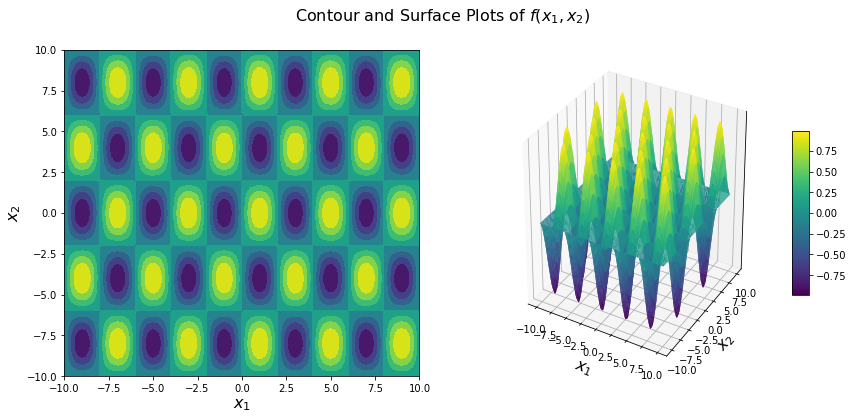

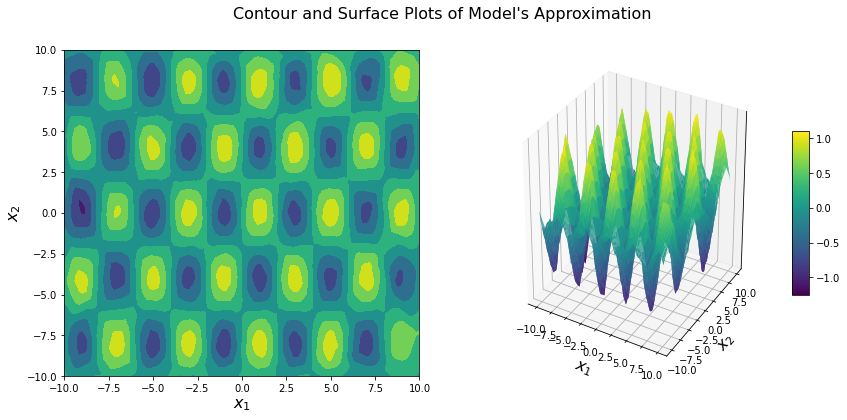

In [ ]:
# plot the original function and the appromixation by the model
plot_func(func1)
plot_approx(model)

## Section 2: Approximating $f_2(x_1,x_2)$
---

In [ ]:
# generate the training and test data using the original function
(x_train, y_train), (x_test, y_test) = generate_data(func2) # <----- training with f2

# clear session of any previous models
clear_session()

# create function approximation model
n_hidden = 200
model = Sequential([
    Dense(n_hidden, input_shape=(2,), activation='relu'),
    Dense(n_hidden, activation='relu'),
    Dense(1)
])

# make loss function and optimizer and compile the model
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['mean_absolute_error'])

# fit the model to the new function
history = model.fit(x_train, y_train, epochs=20, batch_size=500, verbose=0)

# evaluate the model using the test data
model.evaluate(x_test, y_test, verbose=1)

1563/1563 [==============================] - 2s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0734


[0.00827764067798853, 0.07341013848781586]

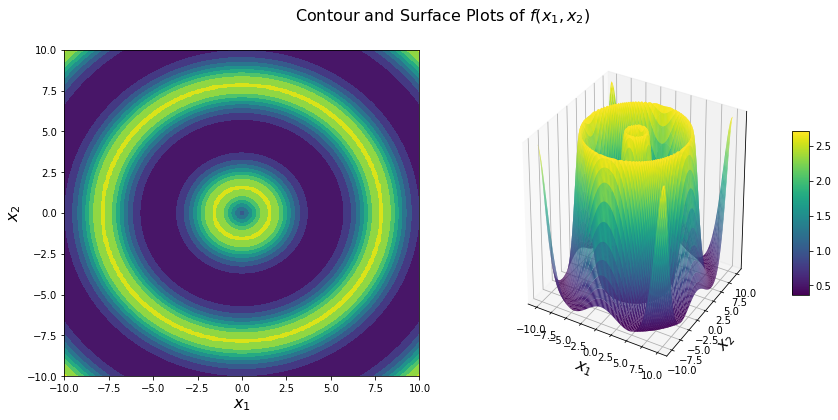

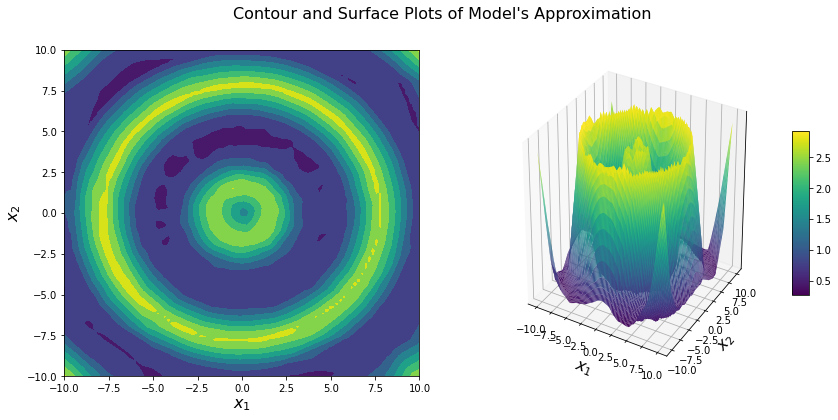

In [ ]:
plot_func(func2)
plot_approx(model)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 41,001
Trainable params: 41,001
Non-trainable params: 0
_________________________________________________________________
